# Variational AutoEncoder Code
This notebook is an implementation of a variational auto-encoder which was taken from https://blog.lancedb.com/training-a-variational-autoencoder-from-scratch-with-the-lance-file-format/


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import io

from PIL import Image
from tqdm import tqdm


from matplotlib import pyplot as plt

import requests
import tarfile
import os
import time

import pyarrow as pa
import lance


### Variational Autoencoder Configuration Breakdown
BATCH_SIZE:
- The number of samples processed together in one forward/backward pass before updating weights

IN_RESOLUTION:
- Input image resolution (width & height)

IN_CHANNELS: 
- Number of channels in the input
-- For RGB images->3 channels
-- For greyscale->1 channel

NUM_EPOCHS:
- Number of full passes through the dataset during training
- Higher epoch -> more opportunities for the model to converge

LEARNING_RATE: 
- Step size used by the optimiser to adjust wieghts
- Smaller -> more stable training but slower
- Larger -> faster, but may overshoot

HIDDEN_DIMS: 
- Defines the number of feature maps in each convolutional layer of the encoder/decoder
- Controls capacity & compression power. eg:
Layer 1: 64 filters
Layer 2: 128 filters
Layer 3: 256 filters
Layer 4: 512 filters

LATENT_DIM_SIZE: 
- Size of the latent space (bottleneck vector)
- size may depend on the image training data size

In [ ]:
vae_config = {
    "BATCH_SIZE": 40,
    "IN_RESOLUTION": 256,
    "IN_CHANNELS": 3,
    "NUM_EPOCHS": 300,
    "LEARNING_RATE": 1e-4,
    "HIDDEN_DIMS":[256, 512, 1024, 2048],
    "LATENT_DIM_SIZE": 256,
}

### Utility function to visualise generated data.

In [3]:
def draw_image_grid(samples):
    images = samples[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

In [4]:
class CustomImageDataset(data.Dataset):
    def __init__(self, classes, lance_dataset, transform=None):
        self.classes = classes
        self.ds = lance.dataset(lance_dataset)
        self.transform = transform

    def __len__(self):
        return self.ds.count_rows()

    def __getitem__(self, idx):
        raw_data = self.ds.take([idx], columns=['image', 'label']).to_pydict()
        img_data, label = raw_data['image'][0], raw_data['label'][0]

        img = Image.open(io.BytesIO(img_data))

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.classes.index(label)
        return img, label

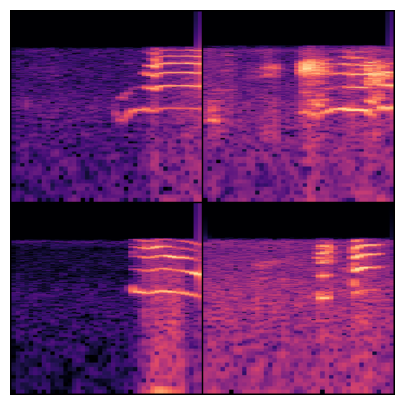

In [5]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # -1 to 1
    ]
)
classes = ('cat')

lance_train_dataset = CustomImageDataset(
    classes,
    "cat-spectrograms-2/cat-spectrograms-2_train.lance/",
    transform=train_transform
)

lance_train_loader = torch.utils.data.DataLoader(
    lance_train_dataset,
    batch_size=vae_config["BATCH_SIZE"],
    shuffle=True
)

images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

### VAE Class Defintion 

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(vae_config["IN_CHANNELS"], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*32*32, vae_config["LATENT_DIM_SIZE"])
        self.fc_logvar = nn.Linear(128*32*32, vae_config["LATENT_DIM_SIZE"])

        # Decoder
        self.decoder_input = nn.Linear(vae_config["LATENT_DIM_SIZE"], 128*32*32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, vae_config["IN_CHANNELS"], kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # change forward - add noise
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 32, 32)
        return self.decoder(z), mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, vae_config["LATENT_DIM_SIZE"]).to(device)
        return self.decoder(self.decoder_input(z).view(-1, 128, 32, 32))

### Training the data

In [7]:
device = "cpu" #change to "cuda" if you have an NVIDIA CPU

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    # change input
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=vae_config["LEARNING_RATE"])

Epoch 1/100: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it, Loss=1.91e+6]


Epoch [1/100] Average Loss: 73771.4963


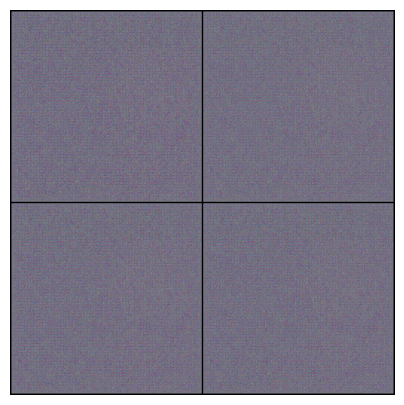

Epoch 2/100: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=1.48e+6]


Epoch [2/100] Average Loss: 61186.0726


Epoch 3/100: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=1.13e+6]


Epoch [3/100] Average Loss: 45847.9651


Epoch 4/100: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=7.96e+5]


Epoch [4/100] Average Loss: 33110.9134


Epoch 5/100: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=5.71e+5]


Epoch [5/100] Average Loss: 23765.8036


Epoch 6/100: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=4.91e+5]


Epoch [6/100] Average Loss: 19073.4952


Epoch 7/100: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, Loss=3.91e+5]


Epoch [7/100] Average Loss: 16449.0705


Epoch 8/100: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=4.13e+5]


Epoch [8/100] Average Loss: 14411.2845


Epoch 9/100: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it, Loss=3.51e+5]


Epoch [9/100] Average Loss: 12940.5945


Epoch 10/100: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it, Loss=3.18e+5]


Epoch [10/100] Average Loss: 11860.6142


Epoch 11/100: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it, Loss=3.17e+5]


Epoch [11/100] Average Loss: 10948.0265


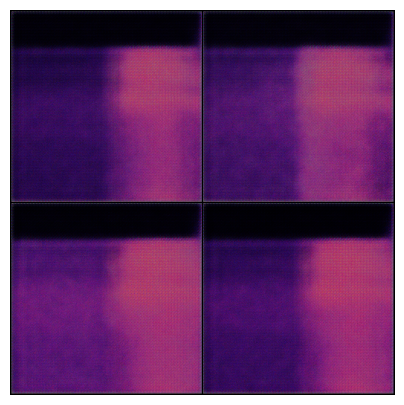

Epoch 12/100: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, Loss=2.98e+5]


Epoch [12/100] Average Loss: 10180.8009


Epoch 13/100: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=2.88e+5]


Epoch [13/100] Average Loss: 9574.4222


Epoch 14/100: 100%|██████████| 8/8 [00:19<00:00,  2.43s/it, Loss=2.67e+5]


Epoch [14/100] Average Loss: 9112.1390


Epoch 15/100: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it, Loss=2.27e+5]


Epoch [15/100] Average Loss: 8767.3823


Epoch 16/100: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it, Loss=2.28e+5]


Epoch [16/100] Average Loss: 8486.1680


Epoch 17/100: 100%|██████████| 8/8 [00:17<00:00,  2.21s/it, Loss=2.09e+5]


Epoch [17/100] Average Loss: 8211.3164


Epoch 18/100: 100%|██████████| 8/8 [00:16<00:00,  2.09s/it, Loss=2.22e+5]


Epoch [18/100] Average Loss: 7984.2852


Epoch 19/100: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, Loss=2.12e+5]


Epoch [19/100] Average Loss: 7763.0897


Epoch 20/100: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it, Loss=2.08e+5]


Epoch [20/100] Average Loss: 7589.2978


Epoch 21/100: 100%|██████████| 8/8 [00:18<00:00,  2.26s/it, Loss=2.05e+5]


Epoch [21/100] Average Loss: 7445.6442


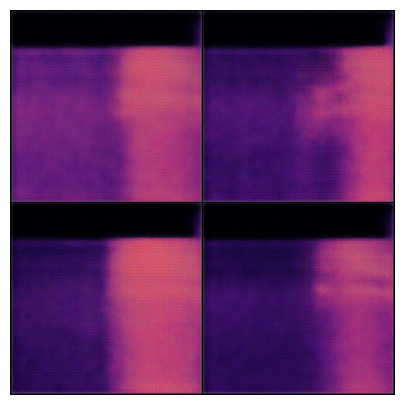

Epoch 22/100: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it, Loss=2.03e+5]


Epoch [22/100] Average Loss: 7277.7059


Epoch 23/100: 100%|██████████| 8/8 [00:17<00:00,  2.20s/it, Loss=1.98e+5]


Epoch [23/100] Average Loss: 7168.3303


Epoch 24/100: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=1.91e+5]


Epoch [24/100] Average Loss: 6995.2990


Epoch 25/100: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=1.93e+5]


Epoch [25/100] Average Loss: 6868.2141


Epoch 26/100: 100%|██████████| 8/8 [00:16<00:00,  2.10s/it, Loss=1.79e+5]


Epoch [26/100] Average Loss: 6757.9512


Epoch 27/100: 100%|██████████| 8/8 [00:16<00:00,  2.12s/it, Loss=1.86e+5]


Epoch [27/100] Average Loss: 6653.4349


Epoch 28/100: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it, Loss=1.86e+5]


Epoch [28/100] Average Loss: 6557.0019


Epoch 29/100: 100%|██████████| 8/8 [00:17<00:00,  2.20s/it, Loss=1.74e+5]


Epoch [29/100] Average Loss: 6481.2030


Epoch 30/100: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it, Loss=1.75e+5]


Epoch [30/100] Average Loss: 6389.9843


Epoch 31/100: 100%|██████████| 8/8 [00:17<00:00,  2.13s/it, Loss=1.7e+5] 


Epoch [31/100] Average Loss: 6318.6435


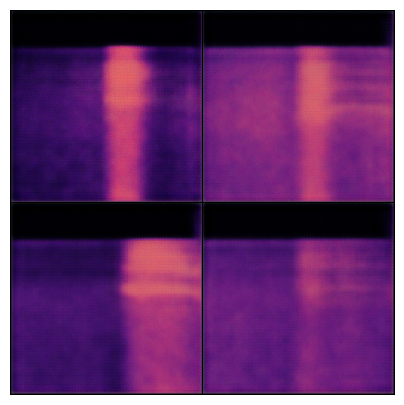

Epoch 32/100: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, Loss=1.81e+5]


Epoch [32/100] Average Loss: 6249.2758


Epoch 33/100: 100%|██████████| 8/8 [00:17<00:00,  2.20s/it, Loss=1.79e+5]


Epoch [33/100] Average Loss: 6160.5094


Epoch 34/100: 100%|██████████| 8/8 [00:17<00:00,  2.13s/it, Loss=1.73e+5]


Epoch [34/100] Average Loss: 6074.9501


Epoch 35/100: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it, Loss=1.69e+5]


Epoch [35/100] Average Loss: 6016.8829


Epoch 36/100: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it, Loss=1.65e+5]


Epoch [36/100] Average Loss: 5957.7688


Epoch 37/100: 100%|██████████| 8/8 [00:18<00:00,  2.26s/it, Loss=1.65e+5]


Epoch [37/100] Average Loss: 5917.9887


Epoch 38/100: 100%|██████████| 8/8 [00:17<00:00,  2.25s/it, Loss=1.68e+5]


Epoch [38/100] Average Loss: 5849.4509


Epoch 39/100: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, Loss=1.66e+5]


Epoch [39/100] Average Loss: 5810.6419


Epoch 40/100: 100%|██████████| 8/8 [00:20<00:00,  2.55s/it, Loss=1.6e+5] 


Epoch [40/100] Average Loss: 5808.7034


Epoch 41/100: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it, Loss=1.61e+5]


Epoch [41/100] Average Loss: 5758.3632


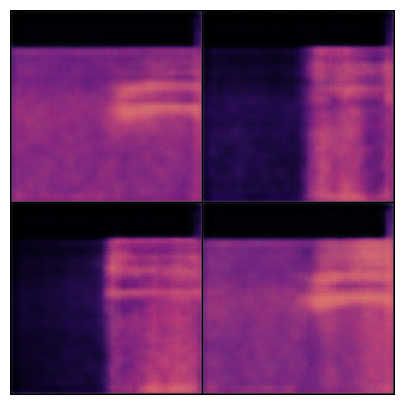

Epoch 42/100: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=1.61e+5]


Epoch [42/100] Average Loss: 5732.0840


Epoch 43/100: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=1.59e+5]


Epoch [43/100] Average Loss: 5645.2335


Epoch 44/100: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it, Loss=1.56e+5]


Epoch [44/100] Average Loss: 5639.9487


Epoch 45/100: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it, Loss=1.6e+5] 


Epoch [45/100] Average Loss: 5647.9119


Epoch 46/100: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it, Loss=1.58e+5]


Epoch [46/100] Average Loss: 5587.1118


Epoch 47/100: 100%|██████████| 8/8 [00:18<00:00,  2.25s/it, Loss=1.53e+5]


Epoch [47/100] Average Loss: 5504.1787


Epoch 48/100: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, Loss=1.51e+5]


Epoch [48/100] Average Loss: 5452.5591


Epoch 49/100: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it, Loss=1.46e+5]


Epoch [49/100] Average Loss: 5421.5129


Epoch 50/100: 100%|██████████| 8/8 [00:19<00:00,  2.44s/it, Loss=1.5e+5] 


Epoch [50/100] Average Loss: 5360.5830


Epoch 51/100: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, Loss=1.54e+5]


Epoch [51/100] Average Loss: 5320.2179


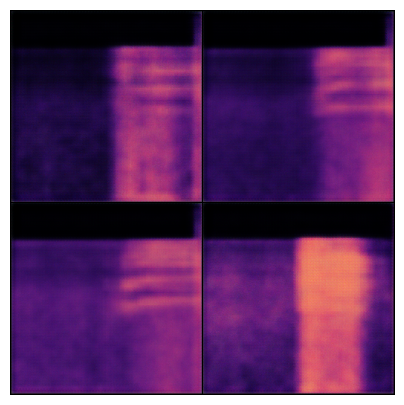

Epoch 52/100: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it, Loss=1.49e+5]


Epoch [52/100] Average Loss: 5294.4953


Epoch 53/100: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, Loss=1.51e+5]


Epoch [53/100] Average Loss: 5279.8058


Epoch 54/100: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it, Loss=1.49e+5]


Epoch [54/100] Average Loss: 5246.7751


Epoch 55/100: 100%|██████████| 8/8 [00:18<00:00,  2.29s/it, Loss=1.46e+5]


Epoch [55/100] Average Loss: 5210.0662


Epoch 56/100: 100%|██████████| 8/8 [00:17<00:00,  2.21s/it, Loss=1.46e+5]


Epoch [56/100] Average Loss: 5190.1328


Epoch 57/100: 100%|██████████| 8/8 [00:17<00:00,  2.25s/it, Loss=1.46e+5]


Epoch [57/100] Average Loss: 5157.6747


Epoch 58/100: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it, Loss=1.43e+5]


Epoch [58/100] Average Loss: 5122.6668


Epoch 59/100: 100%|██████████| 8/8 [00:17<00:00,  2.21s/it, Loss=1.41e+5]


Epoch [59/100] Average Loss: 5106.6032


Epoch 60/100: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it, Loss=1.41e+5]


Epoch [60/100] Average Loss: 5116.5406


Epoch 61/100: 100%|██████████| 8/8 [00:17<00:00,  2.17s/it, Loss=1.42e+5]


Epoch [61/100] Average Loss: 5052.6333


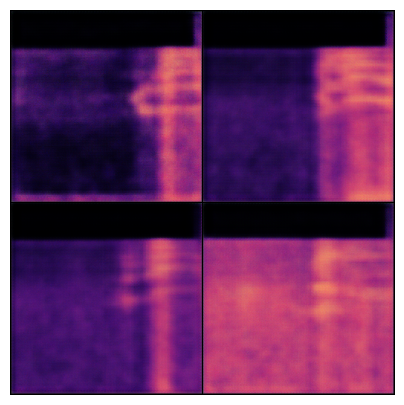

Epoch 62/100: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, Loss=1.37e+5]


Epoch [62/100] Average Loss: 5019.9385


Epoch 63/100: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=1.41e+5]


Epoch [63/100] Average Loss: 5001.3743


Epoch 64/100: 100%|██████████| 8/8 [00:20<00:00,  2.60s/it, Loss=1.39e+5]


Epoch [64/100] Average Loss: 4989.6110


Epoch 65/100: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it, Loss=1.37e+5]


Epoch [65/100] Average Loss: 4956.8110


Epoch 66/100: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, Loss=1.38e+5]


Epoch [66/100] Average Loss: 4920.3041


Epoch 67/100: 100%|██████████| 8/8 [00:17<00:00,  2.21s/it, Loss=1.36e+5]


Epoch [67/100] Average Loss: 4893.2393


Epoch 68/100: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, Loss=1.35e+5]


Epoch [68/100] Average Loss: 4859.6221


Epoch 69/100: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=1.38e+5]


Epoch [69/100] Average Loss: 4878.0767


Epoch 70/100: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, Loss=1.35e+5]


Epoch [70/100] Average Loss: 4830.1570


Epoch 71/100: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, Loss=1.34e+5]


Epoch [71/100] Average Loss: 4839.1237


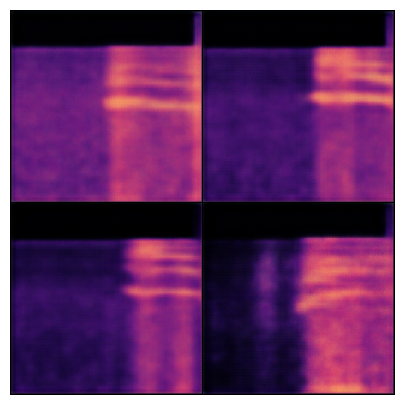

Epoch 72/100: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it, Loss=1.39e+5]


Epoch [72/100] Average Loss: 4792.2538


Epoch 73/100: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it, Loss=1.31e+5]


Epoch [73/100] Average Loss: 4798.9050


Epoch 74/100: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=1.31e+5]


Epoch [74/100] Average Loss: 4735.7483


Epoch 75/100: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, Loss=1.32e+5]


Epoch [75/100] Average Loss: 4715.4472


Epoch 76/100: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, Loss=1.34e+5]


Epoch [76/100] Average Loss: 4686.8959


Epoch 77/100: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=1.34e+5]


Epoch [77/100] Average Loss: 4673.8368


Epoch 78/100: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, Loss=1.31e+5]


Epoch [78/100] Average Loss: 4635.9662


Epoch 79/100: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=1.28e+5]


Epoch [79/100] Average Loss: 4609.5842


Epoch 80/100: 100%|██████████| 8/8 [00:18<00:00,  2.26s/it, Loss=1.28e+5]


Epoch [80/100] Average Loss: 4583.6225


Epoch 81/100: 100%|██████████| 8/8 [00:17<00:00,  2.15s/it, Loss=1.31e+5]


Epoch [81/100] Average Loss: 4574.9131


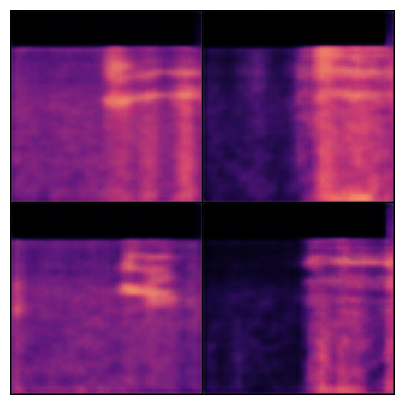

Epoch 82/100: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it, Loss=1.33e+5]


Epoch [82/100] Average Loss: 4550.1558


Epoch 83/100: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it, Loss=1.28e+5]


Epoch [83/100] Average Loss: 4543.3891


Epoch 84/100: 100%|██████████| 8/8 [00:17<00:00,  2.17s/it, Loss=1.25e+5]


Epoch [84/100] Average Loss: 4535.7324


Epoch 85/100: 100%|██████████| 8/8 [00:17<00:00,  2.20s/it, Loss=1.27e+5]


Epoch [85/100] Average Loss: 4508.0340


Epoch 86/100: 100%|██████████| 8/8 [00:17<00:00,  2.24s/it, Loss=1.25e+5]


Epoch [86/100] Average Loss: 4514.0986


Epoch 87/100: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, Loss=1.26e+5]


Epoch [87/100] Average Loss: 4475.3106


Epoch 88/100: 100%|██████████| 8/8 [00:17<00:00,  2.25s/it, Loss=1.24e+5]


Epoch [88/100] Average Loss: 4465.4438


Epoch 89/100: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it, Loss=1.26e+5]


Epoch [89/100] Average Loss: 4473.0311


Epoch 90/100: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=1.24e+5]


Epoch [90/100] Average Loss: 4461.2706


Epoch 91/100: 100%|██████████| 8/8 [00:16<00:00,  2.08s/it, Loss=1.24e+5]


Epoch [91/100] Average Loss: 4411.7470


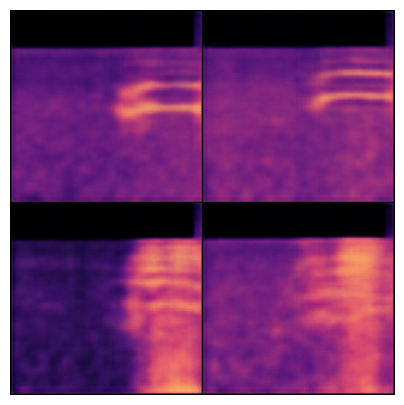

Epoch 92/100: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it, Loss=1.24e+5]


Epoch [92/100] Average Loss: 4412.4751


Epoch 93/100: 100%|██████████| 8/8 [00:17<00:00,  2.17s/it, Loss=1.23e+5]


Epoch [93/100] Average Loss: 4371.5790


Epoch 94/100: 100%|██████████| 8/8 [00:17<00:00,  2.15s/it, Loss=1.19e+5]


Epoch [94/100] Average Loss: 4334.1697


Epoch 95/100: 100%|██████████| 8/8 [00:17<00:00,  2.16s/it, Loss=1.21e+5]


Epoch [95/100] Average Loss: 4332.0954


Epoch 96/100: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it, Loss=1.21e+5]


Epoch [96/100] Average Loss: 4309.3404


Epoch 97/100: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, Loss=1.19e+5]


Epoch [97/100] Average Loss: 4306.3735


Epoch 98/100: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it, Loss=1.22e+5]


Epoch [98/100] Average Loss: 4284.5565


Epoch 99/100: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it, Loss=1.19e+5]


Epoch [99/100] Average Loss: 4289.2800


Epoch 100/100: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=1.21e+5]

Epoch [100/100] Average Loss: 4284.3501


In [8]:
for epoch in range(vae_config["NUM_EPOCHS"]):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(lance_train_loader), total=len(lance_train_loader), desc=f'Epoch {epoch+1}/{vae_config["NUM_EPOCHS"]}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(lance_train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{vae_config["NUM_EPOCHS"]}] Average Loss: {avg_loss:.4f}')

    # show and display a sample of the reconstructed images
    if epoch % 10 == 0:
        with torch.no_grad():
            sampled_images = model.sample(num_samples=4)
            draw_image_grid(recon_batch.cpu())

### The Reconstructed Images

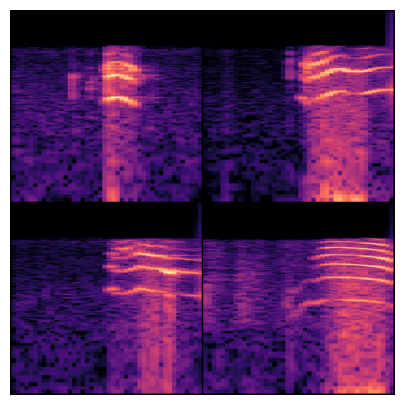

In [9]:
images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

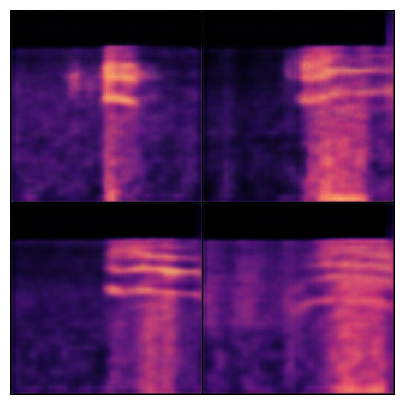

In [10]:
with torch.no_grad():
    recon_images, _, _ = model(images.to(device))
draw_image_grid(recon_images.cpu())